# Using `ehyd_reader` to analyze and export a number of wells and stations

As shown in the [basic demonstration](https://github.com/joha1/ehyd_reader/blob/master/examples/demonstration1.ipynb) `ehyd_reader` can easily read and plot a single ehyd csv file.

But the benefit of using a scripting language like Python of course lies in the ability to automate the handling of multiple files.
In this Example, we will take a closer look at the [Aichfeld region](https://de.wikipedia.org/wiki/Aichfeld) (also called Judenburg–Knittelfelder–Becken), a large basin in the upper Mur valley. 
It covers an area of around $70 km^2$ at an average elevation of about 650 m a.s.l. 
Besides the tertiary fill down to 1000 m b.g.l. which was mined for coal, it's filled with up to 70 meters of fluvio-glacial sediment, housing significant amounts of groundwater (see [Haas & Birk (2017)](www.hydrol-earth-syst-sci.net/21/2421/2017/) for a more detailed description and further reading).
If you look at this region in ehyd (search for *Zeltweg* in the search box for the town right in its middle) you see that there's dozens of groundwater montiring wells as well as a few precipitation and river stations available.

In this notebook, we want to download them, to some first analysis and visualization and then export them to store them for further work.


Unfortunately, [ehyd.gv.at](https://ehyd.gv.at/) doesn not provide an API for bulk downloads, so we either have to download the needed files by hand, or coerce it into giving them to us in an automated way.

## Downloading the needed data

As shown in the [basic demonstration](https://github.com/joha1/ehyd_reader/blob/master/examples/demonstration1.ipynb) we can download data from the website by specifying a HZB number or by clicking the wells in the region/groundwater body that's interesting to us (with some help from the "Grundwassergebiete" layer under "Karten" in the upper right corner), but that is still a lot of clicking around.

In order to speed up this process, we only want to use the 20 wells having long term data available as listet in the supplement of [Haas & Birk (2017)](www.hydrol-earth-syst-sci.net/21/2421/2017/) and we will use the [urllib.request](https://docs.python.org/3/library/urllib.request.html) library to download.

In [123]:
# First, import the needed modules.
# This assumes you have ehyd_reader.py saved in your current working directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ehyd_reader import ehyd_reader
import urllib.request
import os
import glob

In [11]:
# Set up a list with the HZB numbers from Haas & Birk (2017)
well_list = [309997, 318394, 309989, 314807, 314716, 314864, 315317, 
             309906, 314815, 309948, 315077, 314898, 318386, 314872,
             314922, 310128, 314914, 314732, 310029, 310060]
# We're also interested in the precipitation stations and surface water gauges in the area
precip_list = [101030, 111716, 112771]
surface_list = [211128, 211730, 211136, 211920]

Since the HZB numbers are a country wide, universal identifyier, we can use them to download the wells (or stations) with those numbers from ehyd, like so:

    filename ='groundwater_309997.csv'
    url = 'http://ehyd.gv.at/eHYD/MessstellenExtraData/gw?id=309997&file=4'
    urllib.request.urlretrieve(url, filename)
    
, which we can of course automate with the lists we've set up above.
Note that `urllib.request.urlretrieve(url, filename)` is considered legacy and ["might become deprecated at some point in the future."](https://docs.python.org/dev/library/urllib.request.html#legacy-interface).
However, since this threat is now about 10 years old and this is the most simple way to download a file we'll just hope that this wont happen.

Unfortunately, the HZB number is not the only variable that changes in the url, so we either need quite a bit of string processing, or we simply run the downloader three times, once for each type of data.

In [29]:
# Set up a directory for the data to be downloaded into
os.mkdir('downloads')

In [30]:
# Let's loop over the three lists
for i in well_list:
    url = 'https://ehyd.gv.at/eHYD/MessstellenExtraData/gw?id={0}&file=4'.format(i)
    filename = ('downloads/GW_{0}.csv'.format(i))
    urllib.request.urlretrieve(url, filename)
for i in precip_list:
    url = 'https://ehyd.gv.at/eHYD/MessstellenExtraData/nlv?id={0}&file=2'.format(i)
    filename = ('downloads/P_{0}.csv'.format(i))
    urllib.request.urlretrieve(url, filename)
for i in surface_list:
    url = 'https://ehyd.gv.at/eHYD/MessstellenExtraData/owf?id={0}&file=7'.format(i)
    filename = ('downloads/S_{0}.csv'.format(i))
    urllib.request.urlretrieve(url, filename)

If you look into your downloads folder, you should see 27 files.
However, as of this writing, one of them (`GW_314864.csv`) has a size of 0 bytes, meaning that ehyd has no data for this well.
Besides the big issue of reproducible research, an empty file is of course rather hard to read in, so we have to delete it.
Also, note the `/gw?id=`, `/nlv?id=` and `owf?id=` parts of the urls.
Obviously, they specify what type of data we're asking from ehyd (`g`rund`w`asser \[groundw water\], `n`iederschlag \[precipitation\], `o`berflächen`w`asser \[surface water\]).
However, there is also the `&file=` part. 
The first assumption would be that this is another specifier for the type of data, with `7` = surface water and so on, but if you try the exact loops from above with other data, you will likely run into many 0 bytes files, since this parameter changes, depending on what kind of data is available from a station.
For the case of surface water, it only appears to be `file=7` for stations that have flow rates available.
For gauging stations that don't, `file=4` applies.
The same issue also applies to precipitation, where we can have `file=2`, `3` or `5`.

Since we don't have a proper API, we need to download the file first, test for its size and if it's empty, move on to the next file type, e.g.:

    for i in precip_list:
        url = 'https://ehyd.gv.at/eHYD/MessstellenExtraData/nlv?id={0}&file=2'.format(i)
        filename = ('downloads/P_{0}.csv'.format(i))
        urllib.request.urlretrieve(url, filename)
        if os.path.getsize(filename) == 0:
            os.remove(filename)
            url = 'https://ehyd.gv.at/eHYD/MessstellenExtraData/nlv?id={0}&file=3'.format(i)
            urllib.request.urlretrieve(url, filename)
            if os.path.getsize(filename) == 0:
                os.remove(filename)
                url = 'https://ehyd.gv.at/eHYD/MessstellenExtraData/nlv?id={0}&file=5'.format(i)
                urllib.request.urlretrieve(url, filename)
                # And a final remove if the station has vanished
                if os.path.getsize(filename) == 0:
                    os.remove(filename)
                    print('Station', i, 'does not exist anymore!)
        time.sleep(np.random.rand()/2)
        # And maybe some wait time so that we don't run into a DOS protection 
        # when we're trying to download a lot of files.
                    

Now, assuming we deleted the missing station, either by hand or by modifying the downloader above, we should have a `downloads` directory with 26 csv files, from about 23 to 555 KB in size.

## Reading the data

Let's read them with `ehyd_reader` and turn them into a pandas dataframe:

In [47]:
# Set up a list of the csv files, an empty dataframe to be filled 
# and set our desired output to dataframe and loop over all the files.
csv_list = glob.glob('downloads/*.csv*')
Aichfeld = pd.DataFrame()
output = 'df'

for file in csv_list:
    df = ehyd_reader(file, output)
    Aichfeld = pd.concat([Aichfeld, df], axis=1)

HZB: 315317
Station got moved during its livetime.
Sation 315317 was moved by 37 meters.
HZB: 101030
HZB: 309997
Station got moved during its livetime.
Sation 309997 was moved by 41 meters.
HZB: 318386
Station got moved during its livetime.
Sation 318386 was moved by 0 meters.
HZB: 211730
HZB: 314815
Station got moved during its livetime.
Sation 314815 was moved by 20 meters.
HZB: 211136
Station got moved during its livetime.
Sation 211136 was moved by 92 meters.
HZB: 314732
Station got moved during its livetime.
Sation 314732 was moved by 37 meters.
more than 3 consecutive NaN in monthly data
HZB: 314898
Station got moved during its livetime.
Sation 314898 was moved by 41 meters.
HZB: 310029
Station got moved during its livetime.
Sation 310029 was moved by 0 meters.
HZB: 314922
Station got moved during its livetime.
Sation 314922 was moved by 0 meters.
HZB: 309989
Station got moved during its livetime.
Sation 309989 was moved by 0 meters.
HZB: 309948
Station got moved during its livet

As we have seen, this takes some noticeable time (about 15 seconds on an average laptop of moderate age) and prints out a lot of information.
For almost all of the stations (or wells) we get informed about the fact that the station was moved, with some info about the distance.
Interestingly, most of the times this distance is 0 meters, so the move was either within the accuracy of the data (originally in degrees, minutes and seconds) or there has been a second survey that confirmend the original one.
In either case, the movement is small enough for the data and accuracy we're interested in.

Another message of note is `more than 3 consecutive NaN in monthly data`, meaning that this well has a period (or periods) of more than 3 months of consecutive missing data.
However, since there is no `10 percent of data missing` message, this only applies to a somewhat small part of the time series.
It is up to the user to decide what to do with such data.
In this example case, we're going to ignore it.

So let's see what we have produced:


In [48]:
Aichfeld.head()

datatype                                              Groundwater  \
StationName                                  Pausendorf, Br  2525   
HZB                                                        315317   
HD_num                                                     uw2525   
DBMS_num                                                  6002279   
CatchmentName   Aichfeld-Murboden (Judenburg - Knittelfeld) [MUR]   
CatchmentSymbol                                               MUR   
Subcatchment                                360 Aichfeld-Murboden   
RegName                                             HD-Steiermark   
Province                                                      NaN   
Operator                                  Hydrographischer Dienst   
CatchmentSize                                                 NaN   
Lat                                                     47.207222   
Lon                                                     14.796944   
StationMove                                                 37.34   
elev                                                       661.26   
depth                                                      644.06   
teufe                                                        17.2   
DataError                                                no_error   
MetaError                                           Station_moved   
date                                                                
1964-09-01                                                    NaN   
1964-10-01                                                    NaN   
1964-11-01                                                    NaN   
1964-12-01                                                    NaN   
1965-01-01                                                    NaN   

datatype                  Precipitation  \
StationName                 Gasselsdorf   
HZB                              101030   
HD_num                           NL2374   
DBMS_num                        6002966   
CatchmentName               Gasselsdorf   
CatchmentSymbol                     NaN   
Subcatchment                        NaN   
RegName                   HD-Steiermark   
Province                            NaN   
Operator        Hydrographischer Dienst   
CatchmentSize                       NaN   
Lat                           47.204722   
Lon                           14.622500   
StationMove                         NaN   
elev                                NaN   
depth                               NaN   
teufe                               NaN   
DataError                      no_error   
MetaError                      no_error   
date                                      
1964-09-01                          NaN   
1964-10-01                          NaN   
1964-11-01                          NaN   
1964-12-01                          NaN   
1965-01-01                          NaN   

datatype                                              Groundwater  \
StationName                                   Spielberg, Br  2487   
HZB                                                        309997   
HD_num                                                     uw2487   
DBMS_num                                                  6002009   
CatchmentName   Aichfeld-Murboden (Judenburg - Knittelfeld) [MUR]   
CatchmentSymbol                                               MUR   
Subcatchment                                360 Aichfeld-Murboden   
RegName                                             HD-Steiermark   
Province                                                      NaN   
Operator                                  Hydrographischer Dienst   
CatchmentSize                                                 NaN   
Lat                                                     47.216111   
Lon                                                     14.764722   
StationMove                                                 41.96   
elev                                               

As explained in the `demonstration1` notebook, we have a dataframe with a somewhat large multiindex, that replicates the metadata that's in the original files, translated to english, with additional information about errors in the data or the metadata.

## Selecting data

We now can use this multiindex to select data for further analysis or visualization.
Let's say we want to grab all the data that has a `DataError` to decide wether we can use it or not.

We're using [`.xs`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html#pandas.DataFrame.xs) since that has a very easy and straightforward syntax.
However, `.xs` can't do advanced selections (e.g. look for things that are NOT label or select multiple labels).
If you prefer short code over verbosity, please consult the [pandas documentation](https://pandas.pydata.org/docs/user_guide/advanced.html) for other slicing and selection methods.



In [62]:
# In order to know what we're going to select, let's have a look at what kind
# of errors we have and how many of them.
Aichfeld.columns.get_level_values('DataError').value_counts()

no_error             23
3+monthsGap           2
Doublemeasurement     1
Name: DataError, dtype: int64

In [64]:
# Most of the data appears to be free of errors, apart from three time series
threeplus = Aichfeld.xs('3+monthsGap', level='DataError', drop_level=False, axis=1)
double = Aichfeld.xs('Doublemeasurement', level='DataError', drop_level=False, axis=1)
Aich_errors = pd.concat((threeplus, double), axis=1)

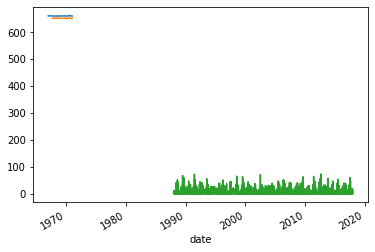

In [84]:
# Let's plot the data, using pandas inbuilt plotting function.
# By default, legend is True and uses the whole multiindex, which will cover the whole plot.
# So we switch it off.
Aich_errors.plot(legend=False)

As we can clearly see, there's something terribly wrong with the data.
Apparently we have two time series around a value of 650 with data only around 1970, and a time series from the late 1980s to 2018 or something with values between 0 and 100.
Obviously, the two short ones must be the two groundwater levels with the 3 months + gap, and the latter one is the precipitation with the double measurement.
Since `ehyd_reader` just discards those, let us focus on the groundwater wells.

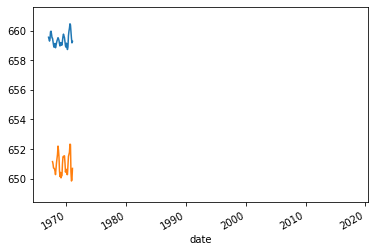

In [88]:
error_GW = Aich_errors.xs('Groundwater', level='datatype', axis=1)
error_GW.plot(legend=False)

Now we can see what's happening in the 70s more clearly, but we obviously do miss a lot of data.
Let's looks at some years and months of the data:

In [90]:
print(error_GW['1970'])
print(error_GW['1990'])

StationName                                    Fisching, Br  2438  \
HZB                                                        314732   
HD_num                                                     uw2438   
DBMS_num                                                  6002221   
CatchmentName   Aichfeld-Murboden (Judenburg - Knittelfeld) [MUR]   
CatchmentSymbol                                               MUR   
Subcatchment                                360 Aichfeld-Murboden   
RegName                                             HD-Steiermark   
Province                                                      NaN   
Operator                                  Hydrographischer Dienst   
CatchmentSize                                                 NaN   
Lat                                                     47.165278   
Lon                                                     14.741389   
StationMove                                                 37.35   
elev                              

As we can clearly see, 1970 is monthly data (`YYYY-MM-DD`) with a water level for every month.
1990 on the other hand is daily data, but we still only have a measurement every month, so `.plot()` can't do much with that data.
In order to be able to plot it (and also, for many other use cases) we need to use `.dropna()`:

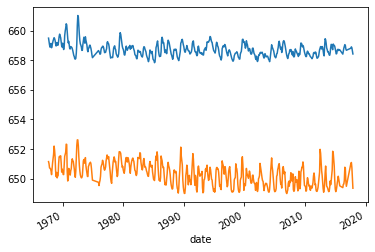

In [93]:
error_GW.dropna().plot(legend=False)

Much better.
However, if we'd look at the raw data and then zoom in to 1967 (`error_GW.dropna()['1967']`), we'd see that it also discards data where only one of the two time series is NaN, so this is not an optimal solution.
Besides, we wanted to see where the NaN's that are a gap in the data are situated, and `.isna()` will not do much good either way. 
If we apply it to the original data (`error_GW.isna()`) we will just get at least 27 NaN for every month, and if we apply to to the the data we removed NaN from (`error_GW.dropna().isna()`) we will obviously not find anything.

**So, what's the cause of this change in frequency and how do we fix it?**

Above, we have just concatenated everything into one dataframe:

    for file in csv_list:
        df = ehyd_reader(file, output)
        Aichfeld = pd.concat([Aichfeld, df], axis=1)
        
This seemed like a good idea at first, since we have `datatype` in the multiindex, so that we can easily select from the dataframe or split it, if needed.
However, we're mixing daily with monthly data, which is causing the issue we've seen above.

So let's read in the data again, in a better way.

## Reading data of multiple datatypes

Instead of putting all of our data in one big dataframe, let us put them into three dataframes, one for each type of data.
We could split up our downloads folder into subfolders and then run `ehyd_reader` on each of them, but we can also leave the downloads as they are, and let the metadata take care of the sorting.
And while we're at it, we also want to have more compact, english csv files written for the data, for further use with other tools.

In [100]:
# Set up the empty dataframes
groundwater = pd.DataFrame()
surface = pd.DataFrame()
precip = pd.DataFrame()
# output is dataframe again, but we also want to write csv files this time
for file in csv_list:
    df = ehyd_reader(file, 'df', write_csv='True')
    datatype = df.columns.get_level_values('datatype')
    if datatype == 'Groundwater':
        groundwater = pd.concat([df, groundwater], axis=1)
    if datatype == 'Riverwater':
        surface = pd.concat([df, surface], axis=1)
    if datatype == 'Precipitation':
        precip = pd.concat([df, precip], axis=1)


HZB: 315317
Station got moved during its livetime.
Sation 315317 was moved by 37 meters.
HZB: 101030
HZB: 309997
Station got moved during its livetime.
Sation 309997 was moved by 41 meters.
HZB: 318386
Station got moved during its livetime.
Sation 318386 was moved by 0 meters.
HZB: 211730
HZB: 314815
Station got moved during its livetime.
Sation 314815 was moved by 20 meters.
HZB: 211136
Station got moved during its livetime.
Sation 211136 was moved by 92 meters.
HZB: 314732
Station got moved during its livetime.
Sation 314732 was moved by 37 meters.
more than 3 consecutive NaN in monthly data
HZB: 314898
Station got moved during its livetime.
Sation 314898 was moved by 41 meters.
HZB: 310029
Station got moved during its livetime.
Sation 310029 was moved by 0 meters.
HZB: 314922
Station got moved during its livetime.
Sation 314922 was moved by 0 meters.
HZB: 309989
Station got moved during its livetime.
Sation 309989 was moved by 0 meters.
HZB: 309948
Station got moved during its livet

We now have 3 dataframes and 26 new csv files in our working directory. 
If you compare the files in a text editor, you will note that they're an exact image of the dataframes we have been using so far and that they don't have any of the padding of the original files that makes them nice looking in a text editor, but large and hard to read (compare the original `P_111716.csv` at about 550 KB to the new `111716.csv` at about half the size).

Now let's go back to our gapdata in groundwater:

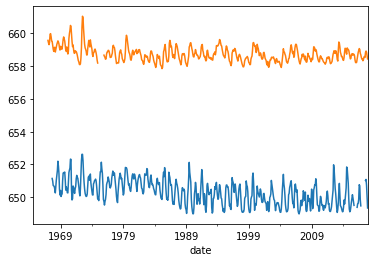

In [102]:
error_GW = groundwater.xs('3+monthsGap', level='DataError', drop_level=False, axis=1)
error_GW.plot(legend=False)


Now we can already see that there's not a lot missing in the data.
Soomething around 1970 something in our top well and something around 2018 at the bottom one.

For the sake of brevity, we assume this plot is already enough to decide wether to use this data or not.

Finally, let's look at some options to export our data.

## Exporting data

We have already produced a lot of csv files with `write_csv='True'`.
That's fine if we need to be able to read in single csv files with other tools (think Excel or Grapher), but in most cases, we're working with multiple files, probably even in python.

We can of course always run `ehyd_reader` again, but let's assume our `groundwater` dataframe is not just 19 time series that took just a few seconds, but a few hundred more, taking the time needed into the minutes.

So we want to have a way to export this dataframe.

Luckily, pandas has [a lot of possibilities to export data](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html). Let's take a look at three particularly useful formats:

### csv

Csv has the benefit of being readable on about any platform with a lot of tools, being both machine and human readable, albeit if you're trying to improve the readability for the one side, the other side will likely suffer (as demonstrated by the human readable, original ehyd files).

It is also responsible for the original csv export in `ehyd_reader`:

        if write_csv == 'True':
            filename_out = str('%s.csv' % (HZB))
            hydroTS.to_csv(filename_out, sep=';')
            
So let's adapt this for the whole groundwater dataframe:






In [106]:
filename = 'Aichfeld_groundwater.csv'
groundwater.to_csv(filename, sep=';')
# Note that sep defaults to ',', as is standard for COMMA seperated values.
# In order to have some more visual difference between the decimal '.' and the
# seperator, we're using ';', to aid human readability.

We now should have an about 90 KB sized csv file, for use with about anything that can read csv files.
This is quite some space saved, compared to the approx. 500 KB of all of the original files.
Also, reading it into python (see below) takes around 20 ms, compared to the 15 seconds for the original files.
However, looking at it in a text editor, it becomes obvious that the savings habe been accomplished by discarding empty space, which can be a hindrance if using a text editor is important.
But on the bright side, importing it back into python is easy and quick:

In [142]:
header = [*range(0,20,1)]
# We can keep the multiindex, we just need to specify a list of the 
# columns that are going to be the index.
Aichfeld_gw = pd.read_csv('Aichfeld_groundwater.csv', sep=';', index_col=0, 
                          header = header, parse_dates=True)

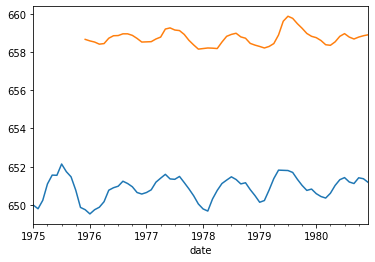

In [150]:
# We can now use this dataframe just like before.
Aichfeld_gw['1975':'1980'].xs('3+monthsGap', level='DataError',
                              drop_level=False, axis=1).plot(legend=False)

### Excel

Let's assume we have to (or want to) use Microsoft Excel (or Libre Office calc) to further work with our data, or to have a well formated way to just scroll around in our data.
Again, pandas has us covered!

In [145]:
groundwater.to_excel('Aichfeld_groundwater.xls')

We now have an excel file that includes a lot of nice details like our date index already formatted as a date field, the data formatted as numbers and the multiindex columns higlighted with borders and the *datatype* index level stretching over all columns.

And of course we can also read this back into python:

In [152]:
# We again have to specify the header and the index as with csv files,
# but the excel file already knows about the date nature of our index.
header = [*range(0,20,1)]
Aichfeld_gw = pd.read_excel('Aichfeld_groundwater.xls',index_col=0, 
                            header = header)

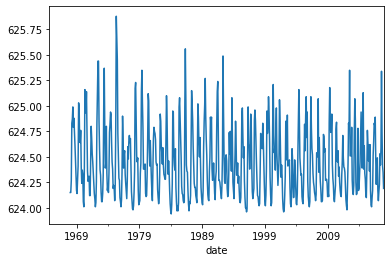

In [155]:
# Useable as always
Aichfeld_gw.xs(314922, level='HZB', drop_level=False, axis=1).plot(legend=False)

If we prefer to use open source software and/or open formats like Libre Office and OpenDocument Spreadsheets we're unfortunately somewhat out of luck.
As of this writing, `read_excel('file.ods', engine='odf')` supports reading ods files, but there's no support for writing them.
So we either have to stick with csv, which will always be readable, or use xls, which by now appears to be pretty well implemented in all (open source) spreadsheet applications.

### HDF

Finally, let's look at a binary file option, [hdf files](https://support.hdfgroup.org/HDF5/whatishdf5.html) (also called h5 or hdf5).
These files can only be opened with specialized software, but for large datasets, they can make reading in data much faster.
For our example, this of course brings no benefits, but for large and complicated files, this in an option worth considering.

Again, writing is straightforward and similar to the other methods:


In [169]:
groundwater.to_hdf('Aichfeld_gw.h5', 'Aichfeld_gw')

Note that this time, we only specify one thing, the `key`, `Aichfeld_gw` in our case.
Reading in needs even less info than excel.
We only need the `key` and the rest (finding the multiindex, making sure it is time series data) is done automatically:


In [176]:
Aichfeld_gw = pd.read_hdf('Aichfeld_gw.h5', 'Aichfeld_gw')

However, if you forget your key, the ease of use turns into the opposite, so again, it is a question of what your priorities are.

Since disk space tends to be plenty, it's probably a good idea to always export a csv and whatever other file you prefer.